# 一、项目背景介绍
该项目目的在于了解PaddleClas中的PP-Shitu图像识别系统应如何配置才能对人脸进行识别

# 二、数据介绍
该项目使用到的数据集为WIDER FACE数据集

WIDER FACE数据集是人脸检测的一个benchmark数据集，包含32203图像，以及393,703个标注人脸，其中，158,989个标注人脸位于训练集，39,,496个位于验证集。每一个子集都包含3个级别的检测难度：Easy，Medium，Hard。这些人脸在尺度，姿态，光照、表情、遮挡方面都有很大的变化范围。</p>
![](https://ai-studio-static-online.cdn.bcebos.com/ed2f076dfa2043bc8cd2231906b7eb07191a0fd9d35649c1a8f38bb6acf3fd77)

WIDER FACE选择的图像主要来源于公开数据集WIDER。制作者来自于香港中文大学，他们选择了WIDER的61个事件类别，对于每个类别，随机选择40%10%50%作为训练、验证、测试集。</p>

# 三、模型介绍
使用了PaddleClas套件中的飞桨PP-Shitu图像识别系统，飞桨识图PP-ShiTu是轻量级图像识别系统，由**检测模型**和**识别模型**构成，集成了目标检测、特征学习、图像检索等模块，广泛适用于各类图像识别任务。CPU上0.2s即可完成在10w+库的图像识别。</p>
本次的PaddleClas V2.3提出了PP-ShiTu超轻量识别。</p>
Metric Learning可以借助一系列观测，根据不一样的任务来自主学习出针对某个特定任务的度量距离函数，通过计算两张图片之间的相似度，使得输入图片被归入到相似度大的图片类别中去，从而学习数据间的的距离或差异，有效地描述样本之间的相似度。相比于传统的识别网络是丢弃经典神经网络最后的softmax层，改成直接输出feature vector，去特征库里面按照Metric Learning寻找最近邻的类别作为匹配项。</p>
拥有了强大的特征提取网络，一套完美的识别系统当然也少不了高效的检索模块。在PP-ShiTu中，PaddleClas使用了经过广泛验证并且能够适配于多端多平台的检索系统：faiss。</p>
这样一来就能够避免每次新增类别重新训练的困难，并且对于样本数量很少的类别，在拥有了较好的特征提取网络的前提下，能够直接将小样本数据补充进特征检索库，避免了训练集的大量数据要求，从而实现识别效果。</p>

总体来看，图像识别一共包含4个步骤。</p>

**第一步：准备好需要识别的图片；</p>
第二步：通过主体检测模型 定位主体所在位置；</p>
第三步：利用metric learning进行特征提取；</p>
第四步：经过检索快速匹配最相似结果；</p>**

本项目使用了PaddleClas推荐的**通用检测 inference 模型和识别 inference 模型**

# 四、模型训练

<h3>1、仓库克隆</h3>

In [1]:
!git clone # https://gitee.com/paddlepaddle/PaddleClas.git -b release/2.3 


Cloning into 'PaddleClas'...
remote: Enumerating objects: 23839, done.
remote: Counting objects: 100% (3722/3722), done.
remote: Compressing objects: 100% (1420/1420), done.
remote: Total 23839 (delta 2530), reused 3331 (delta 2296), pack-reused 20117
Receiving objects: 100% (23839/23839), 154.13 MiB | 5.63 MiB/s, done.
Resolving deltas: 100% (16315/16315), done.
Checking connectivity... done.


<h3>2、安装所需的文件</h3>

In [2]:
pip install --upgrade -r PaddleClas/requirements.txt -i # https://mirror.baidu.com/pypi/simple

In [5]:
!mkdir PaddleClas/deploy/models

<h3>3、下载检测模型和识别模型</h3>

In [10]:
# 下载通用检测 inference 模型并解压
!cd  PaddleClas/deploy/models && wget #https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/rec/models/inference/picodet_PPLCNet_x2_5_mainbody_lite_v1.0_infer.tar && tar -xf picodet_PPLCNet_x2_5_mainbody_lite_v1.0_infer.tar
# 下载识别 inference 模型并解压
!cd  PaddleClas/deploy/models && wget #https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/rec/models/inference/general_PPLCNet_x2_5_lite_v1.0_infer.tar && tar -xf general_PPLCNet_x2_5_lite_v1.0_infer.tar

<h3>4、数据预处理</h3>

In [91]:
%cd

/home/aistudio


In [21]:
!unzip -oq data/data128837/WIDER_FACE_WIDER_train.zip -d PaddleClas/deploy/FACE

In [89]:
!unzip -oq data/data128837/WIDER_FACE_WIDER_test.zip -d PaddleClas/deploy/FACE

In [92]:
!unzip -oq data/data128837/WIDER_FACE_WIDER_val.zip -d PaddleClas/deploy/FACE

In [22]:
!unzip -oq data/data128837/WIDER_FACE_wider_face_split.zip -d PaddleClas/deploy/FACE

In [93]:
%cd ~/PaddleClas/deploy  #本项目大部分操作都以该目录作为根目录进行

/home/aistudio/PaddleClas/deploy


<h3>5、训练集标签生成</h3>

In [67]:
import re
import glob
a = glob.glob('FACE/WIDER_train/images/*/*.jpg')

In [73]:
b = []
for i in a:
    c = re.findall(r"/images/(.+)",i)
    b.append(c[0])

In [74]:
d = []
for i in a:
    e = re.findall(r"/images/(.+)/",i)
    d.append(e[0])

In [36]:
import pandas as pd

In [76]:
label = pd.DataFrame(b)

In [77]:
label['2'] = d

In [80]:
label.to_csv('FACE/WIDER_train/images/train_label.txt',sep='\t',header=None,index=None)  

<h3>6、配置自己需要的索引库更新文件</h3>

In [81]:
%%writefile  ~/work/build_general.yaml
Global:
  rec_inference_model_dir: "./models/general_PPLCNet_x2_5_lite_v1.0_infer"  #  用于提取特征建库的inference模型
  batch_size: 32
  use_gpu: True
  enable_mkldnn: True
  cpu_num_threads: 10
  enable_benchmark: True
  use_fp16: False
  ir_optim: True
  use_tensorrt: False
  gpu_mem: 8000
  enable_profile: False

RecPreProcess:
  transform_ops:
    - ResizeImage:
        size: 224
    - NormalizeImage:
        scale: 0.00392157
        mean: [0.485, 0.456, 0.406]
        std: [0.229, 0.224, 0.225]
        order: ''
    - ToCHWImage:

RecPostProcess: null

# indexing engine config
IndexProcess:
  index_method: "HNSW32" # supported: HNSW32, IVF, Flat
  image_root: "./FACE/WIDER_train/images"
  index_dir: "./FACE/WIDER_train/index"
  data_file:  "./FACE/WIDER_train/images/train_label.txt"
  index_operation: "new" # suported: "append", "remove", "new"
  delimiter: "\t"
  dist_type: "IP"
  embedding_size: 512

Writing /home/aistudio/work/build_general.yaml


<h3>7、建立索引</h3>

In [82]:
!python3.7 python/build_gallery.py -c ~/work/build_general.yaml -o IndexProcess.data_file="./FACE/WIDER_train/images/train_label.txt" -o IndexProcess.index_dir="./FACE/WIDER_train/index"

<h3>8、配置自己需要的识别文件</h3>

In [86]:
%%writefile ~/work/inference_general.yaml
Global:
  # 全局配置
  infer_imgs: "./FACE/WIDER_train/images" # 预测的图片或者预测路径
  det_inference_model_dir: "./models/picodet_PPLCNet_x2_5_mainbody_lite_v1.0_infer"   # 检测inference模型路径
  rec_inference_model_dir: "./models/general_PPLCNet_x2_5_lite_v1.0_infer" # 识别inference模型路径
  rec_nms_thresold: 0.05  # 识别结果的nms阈值
  
  # 主体检测相关配置
  batch_size: 1
  image_shape: [3, 640, 640] # 输入图像的尺度
  threshold: 0.2 # 检测得分阈值
  max_det_results: 100 # 返回检测框的最大值
  labe_list:  # 检测label list
  - foreground

  # 预测引擎相关配置
  use_gpu: True
  enable_mkldnn: True
  cpu_num_threads: 10
  enable_benchmark: True
  use_fp16: False
  ir_optim: True
  use_tensorrt: False
  gpu_mem: 8000
  enable_profile: False

# 检测预处理
DetPreProcess:
  transform_ops:
    - DetResize:
        interp: 2
        keep_ratio: false
        target_size: [640, 640]
    - DetNormalizeImage:
        is_scale: true
        mean: [0.485, 0.456, 0.406]
        std: [0.229, 0.224, 0.225]
    - DetPermute: {}
DetPostProcess: {}

# 识别预处理
RecPreProcess:
  transform_ops:
    - ResizeImage:
        size: 224
    - NormalizeImage:
        scale: 0.00392157
        mean: [0.485, 0.456, 0.406]
        std: [0.229, 0.224, 0.225]
        order: ''
    - ToCHWImage:

RecPostProcess: null

# 索引引擎配置
IndexProcess:
  # 索引文件所在目录
  index_dir: "./FACE/WIDER_train/index"
  # 返回的检索top-k数量
  return_k: 5
  # 得分阈值
  score_thres: 0.5

Overwriting /home/aistudio/work/inference_general.yaml


# 五、模型评估

<h3>1、选取验证集中的0--Parade类进行测试</h3>

In [94]:
!python python/predict_system.py -c ~/work/inference_general.yaml -o Global.infer_imgs="./FACE/WIDER_val/images/0--Parade"

<h3>2、结果展示</h3>

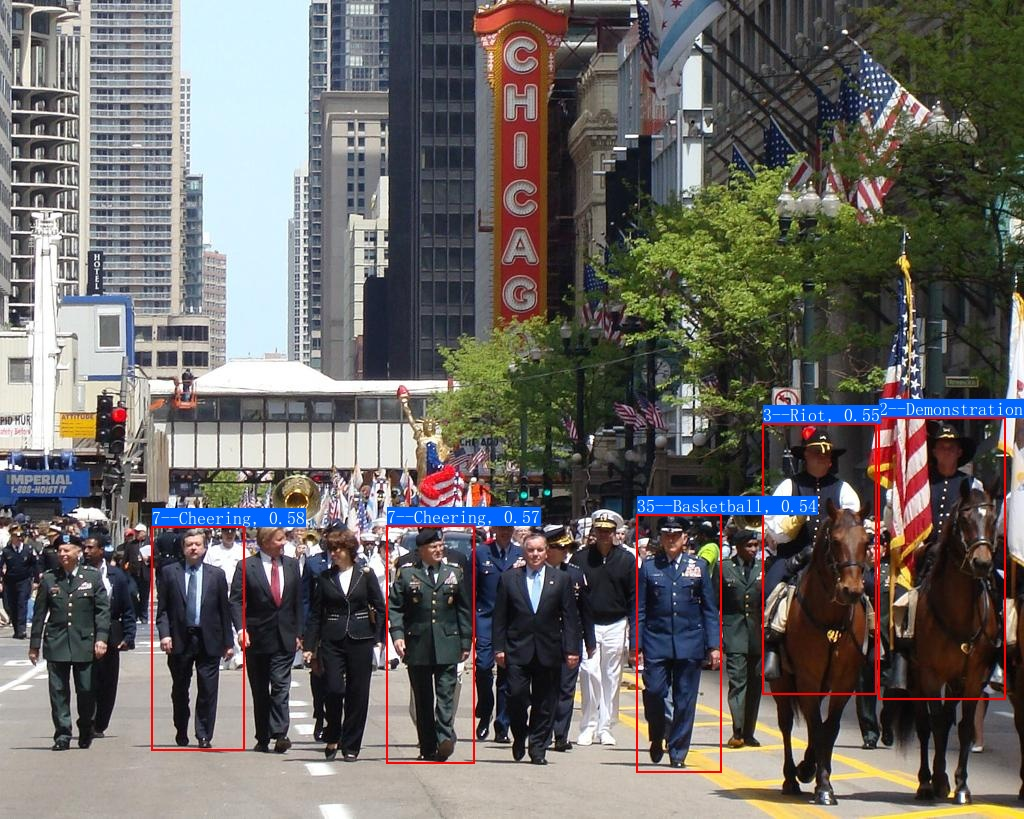

训练集中Parade类型的图片：


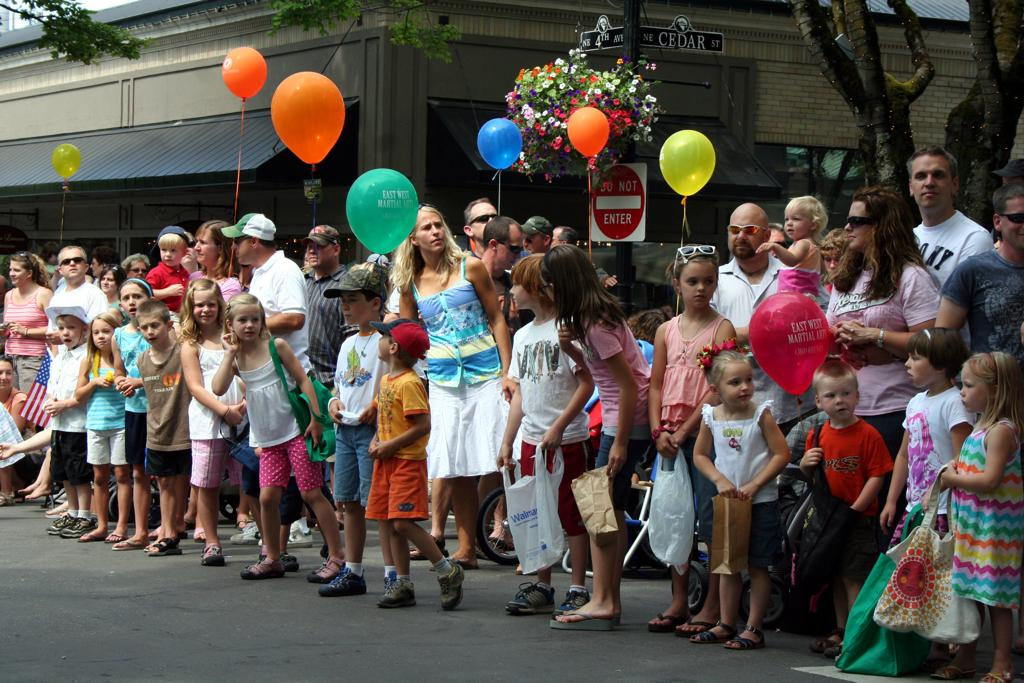

In [103]:
from IPython.display import display, Image
path = "./output/0_Parade_Parade_0_102.jpg"
img = Image(path)
display(img)
print("训练集中Parade类型的图片：")
path = "./FACE/WIDER_train/images/0--Parade/0_Parade_Parade_0_106.jpg"
img = Image(path)
display(img)

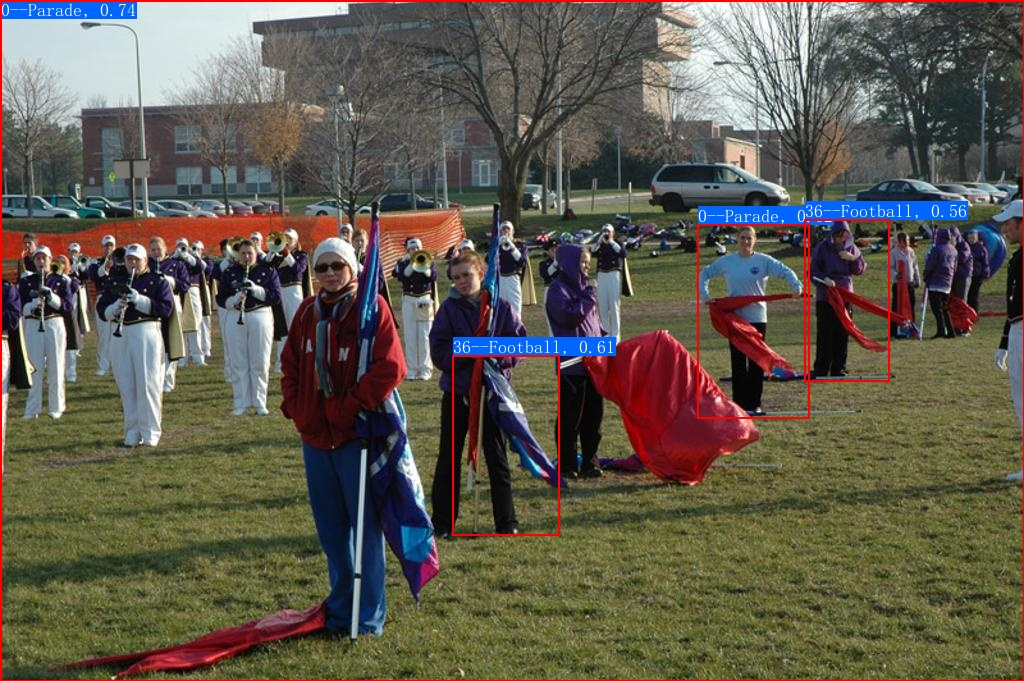

训练集中Parade类型的图片：


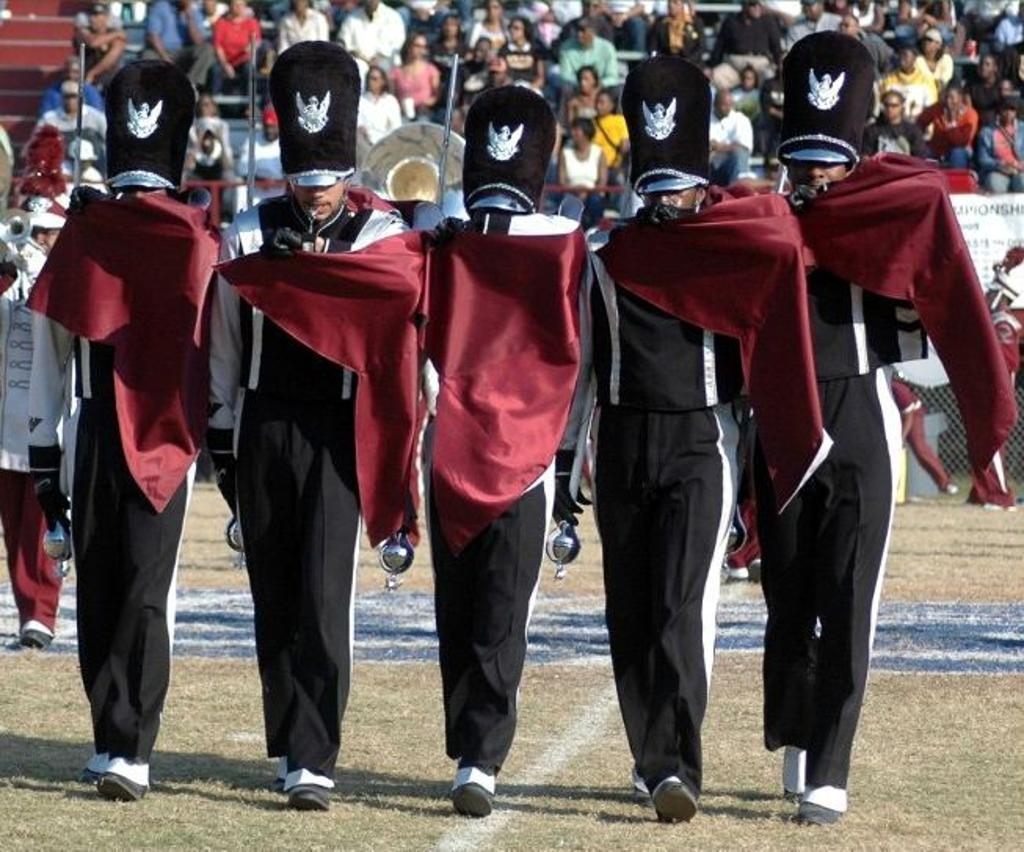

In [109]:
path = "./output/0_Parade_marchingband_1_104.jpg"
img = Image(path)
display(img)
print("训练集中Parade类型的图片：")
path = "./FACE/WIDER_train/images/0--Parade/0_Parade_marchingband_1_778.jpg"
img = Image(path)
display(img)

# 六、总结与升华

本项目仅仅是作为个人在兴趣驱使下的一个小小的实验，因为在浏览PP-Shitu的Github时，发现PP-Shitu提供的检测和识别模型都没有提到人脸，所以想试试看PP-Shitu能否用在人脸上。</p>
不足之处就是这仅仅是一个简单实验，只是了解了PP-Shitu系统的操作以及如何识别自己的数据集，由上方的识别结果可以看到识别的效果很差，检测到的物体有时候不准，识别出来的类别基本上错误。</p>
针对以上问题的改进方法，我的猜想如下：</p>
1. 类别划分再进一步明确。如Parade这一大类，在里面又分为Parade和marchingband两个小类
2. 更换识别模型。在 https://github.com/PaddlePaddle/PaddleClas/blob/release/2.3/docs/zh_CN/quick_start/quick_start_recognition.md 中的第4点提供了**动漫人物识别模型**，考虑到识别动漫人物与识别人脸应该类似，因此可以尝试使用该识别模型进行人脸识别



# 七、个人总结
一位大三的普普通通老百姓，对深度学习有丁点兴趣，目前正在为23年考研备战。

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 